In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader

In [78]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

In [79]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, img_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.gen(x)

In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
img_dim = 28*28
batch_size = 64
num_epochs = 50


In [81]:
disc = Discriminator(img_dim).to(device)
gen = Generator(z_dim, img_dim).to(device)

In [82]:
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [83]:
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)),
    ]
)

In [84]:
dataset = datasets.MNIST(root="./dataset/", transform=transforms, download=True)

In [85]:
train_loader = DataLoader(dataset, batch_size, shuffle=True)

In [86]:
optim_disc = optim.Adam(disc.parameters(), lr=lr)
optim_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

#### Max [ log( D( real ) ) + log( 1 - ( D( G( noise ))))]


In [87]:
for epoch in range(num_epochs):
    print(epoch)
    for batch_idx, (img, _labels) in enumerate(train_loader):
        img = img.view(-1, 784)
        batch_size = img.shape[0]

        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(img).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2

        disc.zero_grad()
        lossD.backward(retain_graph=True)
        optim_disc.step()

        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        optim_gen.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


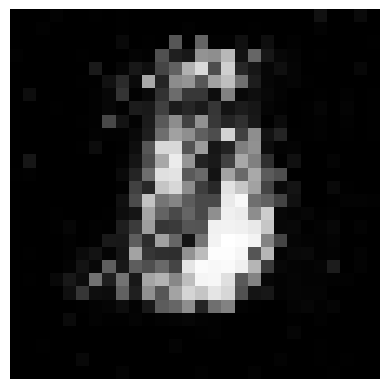

In [88]:
import matplotlib.pyplot as plt

noise = torch.randn(1, z_dim).to(device) # Adjust the batch size as needed

with torch.no_grad(): # We don't need gradients for inference
    generated_image = gen(noise)

generated_image = (generated_image + 1) / 2 # Rescale to [0, 1]
generated_image = generated_image.squeeze().cpu().numpy().reshape(28,28) # Remove batch dimension and move to CPU

plt.imshow(generated_image, cmap='gray') # Assuming the image is grayscale
plt.axis('off')
plt.show()

In [89]:
disc(torch.tensor(generated_image).view(-1,784))

tensor([[4.2437e-06]], grad_fn=<SigmoidBackward0>)